# Conditonal Generation Presentation
## Necessary packages and functions call

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install ema-pytorch==0.2.1;pandas==1.5.0;scikit-learn==1.1.2;scipy==1.8.1;seaborn==0.12.2;tqdm==4.64.1;dm-control==1.0.12;dm-env==1.6;dm-tree==0.1.8;mujoco==2.3.4;gluonts==0.12.6;pyyaml==6.0
import os
import torch
import numpy as np
import sys

sys.path.insert(0,'/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS')
from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

from Utils.metric_utils import display_scores
from Utils.discriminative_metric import discriminative_score_metrics
from Utils.predictive_metric import predictive_score_metrics

import itertools
import yaml
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


from Utils.cross_correlation import CrossCorrelLoss
from engine.solver import Trainer
from Data.build_dataloader import build_dataloader_cond
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully u

## Loading the trained model

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.config_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Config/sines.yaml'
        self.save_dir = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/sinus'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

trainer.train()


dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy"))  # Uncomment the line if dataset other than Sine is used.
fake_data = trainer.sample(num=20, size_every=20, shape=[seq_length, feature_dim])
if dataset.auto_norm:
    fake_data = unnormalize_to_zero_to_one(fake_data)
    np.save(os.path.join(args.save_dir, f'ddpm_fake_sines.npy'), fake_data)

Sampling sine-dataset:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

training complete


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.gpu = 0
        self.config_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Config/sines.yaml'
        self.save_dir = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/sinus'
        self.mode = 'infill'
        self.missing_ratio = 0.5
        self.milestone = 10
        #os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader_cond(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

trainer.load(args.milestone)

Sampling sine-dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

## Sampling

In [ ]:
dataloader, dataset = dl_info['dataloader'], dl_info['dataset']
coef = configs['dataloader']['test_dataset']['coefficient']
stepsize = configs['dataloader']['test_dataset']['step_size']
sampling_steps = configs['dataloader']['test_dataset']['sampling_steps']
seq_length, feature_dim = dataset.window, dataset.var_num
samples, ori_data, masks = trainer.restore(dataloader, [seq_length, feature_dim], coef, stepsize, sampling_steps)

if dataset.auto_norm:
    samples = unnormalize_to_zero_to_one(samples)

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

## Ploting the results

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/sinus/samples/sine_ground_truth_24_test.npy'

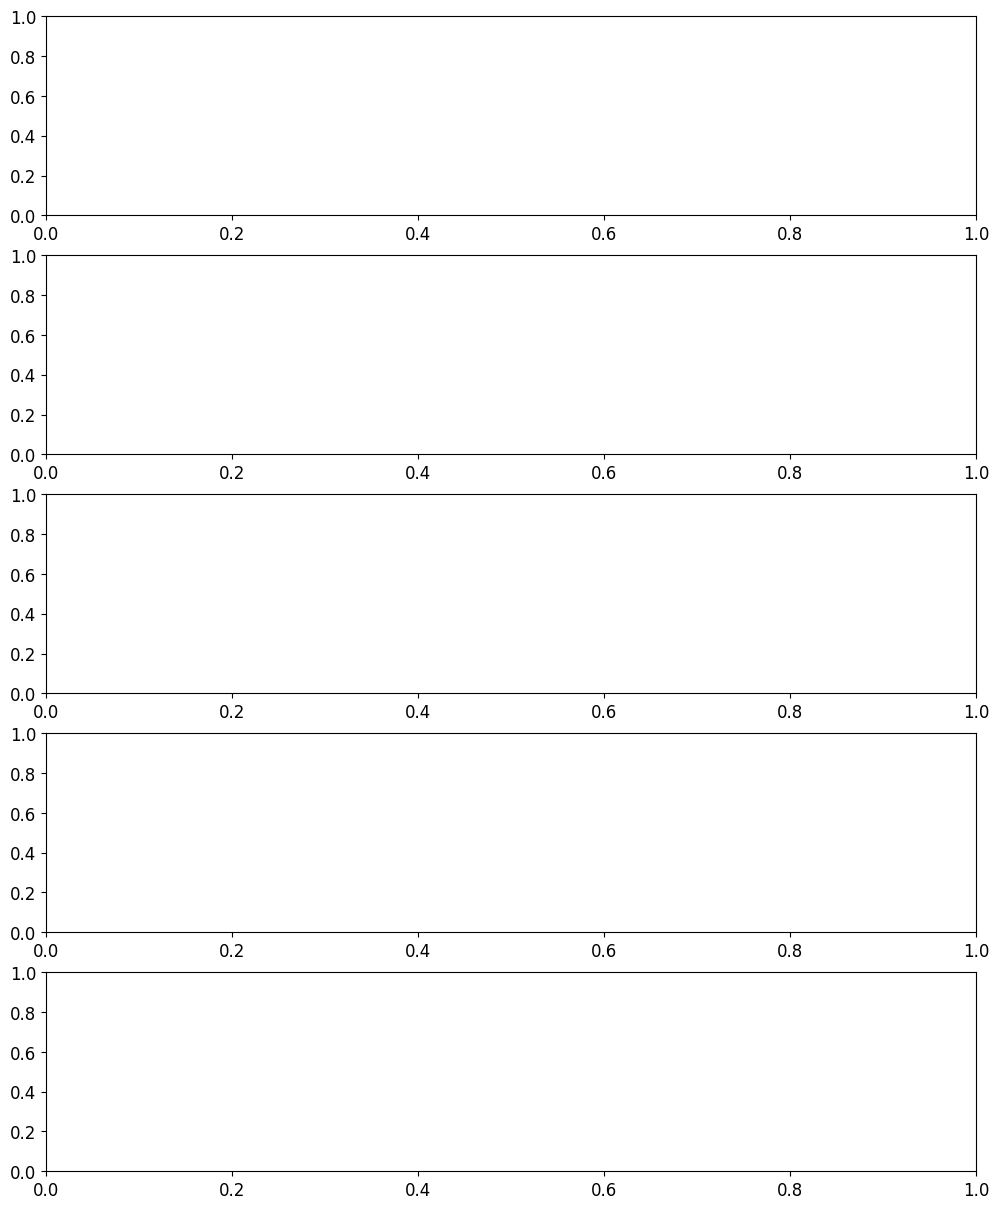

In [ ]:
plt.rcParams["font.size"] = 12
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))

ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_test.npy"))
# ori_data = np.load(os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_test.npy"))  # Uncomment the line if dataset other than Sine is used.
masks = np.load(os.path.join(dataset.dir, f"sine_masking_{seq_length}.npy"))
sample_num, seq_len, feat_dim = ori_data.shape
observed = ori_data * masks

for feat_idx in range(feat_dim):
    df_x = pd.DataFrame({"x": np.arange(0, seq_len), "val": ori_data[0, :, feat_idx],
                         "y": masks[0, :, feat_idx]})
    df_x = df_x[df_x.y!=0]

    df_o = pd.DataFrame({"x": np.arange(0, seq_len), "val": ori_data[0, :, feat_idx],
                         "y": (1 - masks)[0, :, feat_idx]})
    df_o = df_o[df_o.y!=0]
    axes[feat_idx].plot(df_o.x, df_o.val, color='b', marker='o', linestyle='None')
    axes[feat_idx].plot(df_x.x, df_x.val, color='r', marker='x', linestyle='None')
    axes[feat_idx].plot(range(0, seq_len), samples[0, :, feat_idx], color='g', linestyle='solid', label='Diffusion-TS')
    plt.setp(axes[feat_idx], ylabel='value')
    if feat_idx == feat_dim-1:
        plt.setp(axes[-1], xlabel='time')

plt.show()

In [ ]:
class Args_Example:
    def __init__(self) -> None:
        self.gpu = 0
        self.config_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Config/sines.yaml'
        self.save_dir = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/sinus'
        self.mode = 'infill'
        self.missing_ratio = 0.5
        self.milestone = 10
        #os.makedirs(self.save_dir, exist_ok=True)

args =  Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = build_dataloader_cond(configs, args)
model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)

trainer.load(args.milestone)